In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Training a Digit Classifier

### Create Datasets

In [96]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [97]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [98]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

len(three_tensors), len(seven_tensors)

(6131, 6265)

In [99]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [100]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(dim=1)

train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [103]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [101]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [102]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)

valid_dset = list(zip(valid_x,valid_y))

### Create Dataloaders

In [104]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [134]:
coll = range(20)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 5,  9,  8, 15,  4]),
 tensor([16,  0, 12, 18,  6]),
 tensor([19,  3, 17, 11,  1]),
 tensor([ 2, 13,  7, 10, 14])]

In [105]:
valid_dl = DataLoader(valid_dset, batch_size=256)

### 1. Initialize Weights

In [106]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [107]:
weights = init_params((28*28,1))
bias = init_params(1)

In [108]:
weights.shape, weights.T.shape

(torch.Size([784, 1]), torch.Size([1, 784]))

In [139]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

### 2. Prediction

In [140]:
def linear1(xb): 
    return xb@weights + bias

In [141]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [142]:
preds = linear1(batch)
preds

tensor([[-2.6082],
        [ 7.4005],
        [-2.3684],
        [-8.6094]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

### 3. Loss Function

In [143]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### 4. Calculate Gradient

Let's create a mini-batch of size 4 for testing:

In [144]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward() # add gradients

In [145]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0102), tensor([-0.0715]))

### 5. Step

In [146]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

### 6. Accuracy

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [147]:
preds = linear1(batch)
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [False],
        [False]])

That gives us this function to calculate our validation accuracy:

In [148]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

In [149]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

and then put the batches together:

In [150]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [151]:
validate_epoch(linear1)

0.6733

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [152]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.8632

### 7. Iterate

Then do a few more:

In [153]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.914 0.9325 0.9457 0.9545 0.9623 0.9653 0.9677 0.9687 0.9687 0.9706 0.9736 0.9745 0.9745 0.9755 0.9755 0.976 0.9765 0.9765 0.977 0.977 

### Creating an Optimizer

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

In [165]:
linear = nn.Linear(28*28, 1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

In [166]:
w, b = linear.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [167]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

We can create our optimizer by passing in the model's parameters:

In [168]:
opt = BasicOptim(linear.parameters(), lr)

Our training loop can now be simplified to:

In [169]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

In [170]:
validate_epoch(linear_model)

0.9785

Let's put our little training loop in a function, to make things simpler:

In [175]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [177]:
train_model(linear, 20)

0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 0.6255 

### Optimizer with fastai

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

In [178]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8247 0.8467 0.9121 0.9341 0.9477 0.9546 0.9619 0.9658 0.9673 0.9697 0.9726 0.9731 0.9751 0.9761 0.977 0.9775 0.9775 0.9785 0.9785 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

In [179]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `vision_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [180]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

In [181]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636654,0.503310,0.495584,00:01
1,0.469368,0.235132,0.788027,00:02
2,0.174741,0.158291,0.857704,00:01
3,0.077611,0.098348,0.917076,00:01
4,0.041803,0.073607,0.936212,00:02
5,0.027814,0.059712,0.949951,00:02
6,0.022052,0.050907,0.957311,00:01
7,0.019471,0.044999,0.963690,00:01
8,0.018147,0.040815,0.965653,00:01
9,0.017344,0.037708,0.968597,00:01


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [182]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [183]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

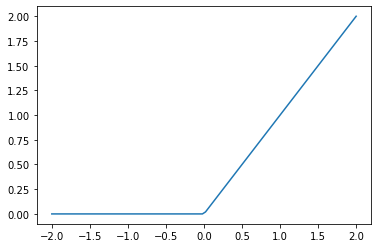

In [184]:
plot_function(F.relu)

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [185]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

In [186]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [187]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.299982,0.406330,0.508341,00:01
1,0.139833,0.225071,0.812561,00:01
2,0.078242,0.114284,0.916094,00:01
3,0.051944,0.077827,0.941119,00:00
4,0.039680,0.061013,0.954367,00:00
5,0.033375,0.051462,0.964671,00:01
6,0.029718,0.045401,0.966143,00:02
7,0.027318,0.041250,0.967125,00:02
8,0.025576,0.038231,0.968597,00:02
9,0.024219,0.035925,0.970069,00:02


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

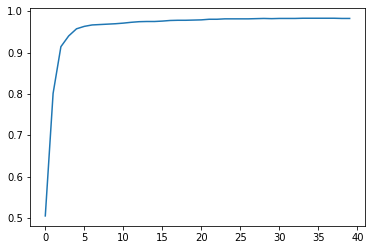

In [133]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

In [134]:
learn.recorder.values[-1][2]

0.98233562707901

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

### Going Deeper

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here is what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082089,0.009578,0.997056,00:11


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.